In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
import wandb
from dotenv import load_dotenv

In [2]:
from scipy.signal import savgol_filter
import scipy.interpolate as interpolate

In [3]:
import torch
print("Torch version:", torch.__version__)
print('cuda available:', torch.cuda.is_available())

Torch version: 2.9.1+cu128
cuda available: False


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cpu


In [39]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("kushagra3204/cricket-ball-dataset-for-yolo")

# print("Path to dataset files:", path)

In [5]:
#load_dotenv()
# get api key from env file
#wandb.login(key=os.getenv('WANDB_API_KEY'))
wandb.login()

wandb: Currently logged in as: smruti-biswal0201 (smruti-biswal0201-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# enable yolo wandb logging using terminal command
os.system('yolo settings wandb=True')
    

✅ Updated 'wandb=True'
JSONDict("/home/smrutibiswal/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/smrutibiswal/Projects/datasets",
  "weights_dir": "/home/smrutibiswal/Projects/edgeFleetAI/weights",
  "runs_dir": "/home/smrutibiswal/Projects/edgeFleetAI/runs",
  "uuid": "6ea89a9c93b11192ad287f89b850c3b86d278a64297084767728991e8f651f55",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


0

In [7]:
DATASET_PATH = os.path.join(os.getcwd(), 'cricket_ball_data')
TEST_PATH = os.path.join(DATASET_PATH, 'test')
TEST_IMAGES_PATH = os.path.join(TEST_PATH, 'images')
TEST_LABELS_PATH = os.path.join(TEST_PATH, 'labels')
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH, 'images')
TRAIN_LABELS_PATH = os.path.join(TRAIN_PATH, 'labels')
VALIDATION_PATH = os.path.join(DATASET_PATH, 'valid')
VALIDATION_IMAGES_PATH = os.path.join(VALIDATION_PATH, 'images')
VALIDATION_LABELS_PATH = os.path.join(VALIDATION_PATH, 'labels')
MODEL_PATH = os.path.join(os.getcwd(), 'model')

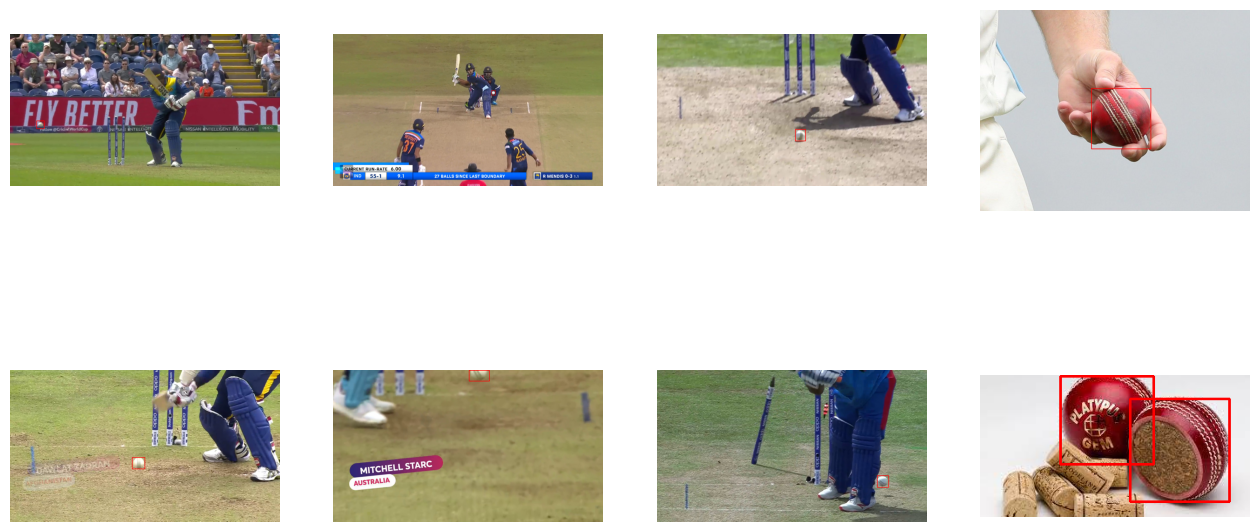

In [8]:
# visualize a few training images with bounding boxes
plt.figure(figsize=(16, 8))

for i in range(8):
    image_files = os.listdir(TRAIN_IMAGES_PATH)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(TRAIN_IMAGES_PATH, random_image_file)
    if random_image_file.endswith('.jpg'):
        label_file = random_image_file.replace('.jpg', '.txt')
    elif random_image_file.endswith('.png'):
        label_file = random_image_file.replace('.png', '.txt')
    label_path = os.path.join(TRAIN_LABELS_PATH, label_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height

        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [9]:
import os
print("CWD:", os.getcwd())
print("YAML exists:", os.path.exists("cricket_ball_data/dataset.yaml"))



CWD: /home/smrutibiswal/Projects/edgeFleetAI
YAML exists: True


In [10]:
with open("cricket_ball_data/dataset.yaml") as f:
    print(f.read())


path: ../cricket_ball_data
train: /home/smrutibiswal/Projects/edgeFleetAI/cricket_ball_data/train/images
val: /home/smrutibiswal/Projects/edgeFleetAI/cricket_ball_data/valid/images
test: /home/smrutibiswal/Projects/edgeFleetAI/cricket_ball_data/test/images

nc: 1
names: ['cricket_ball']



In [11]:
# # train the YOLOv8 model
# model = YOLO('yolov8s.pt')

# # train the model
# model.train(data="cricket_ball_data/dataset.yaml",
#             epochs=20,
#             imgsz=640,
#             batch=8,
#             freeze=15,
#             device=DEVICE,
#             name='cricket_ball_detector')

# train the YOLOv8 model
model = YOLO('yolov8s.pt')

# train the model
model.train(data="cricket_ball_data/dataset.yaml",
            epochs=10,
            imgsz=320,
            batch=8,
            freeze=15,
            device=DEVICE,
            name='cricket_ball_detector')





New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.239 🚀 Python-3.13.11 torch-2.9.1+cu128 CPU (12th Gen Intel Core(TM) i5-12500H)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cricket_ball_data/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=15, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cricket_ball_detector21, n

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


lr/pg0,▃▆█▇▆▅▄▃▂▁
lr/pg1,▃▆█▇▆▅▄▃▂▁
lr/pg2,▃▆█▇▆▅▄▃▂▁
metrics/mAP50(B),▁▅▅▇▇██▇██
metrics/mAP50-95(B),▁▄▄▅▆▇▇▇██
metrics/precision(B),▁▆▆▇▆▆▇▆█▇
metrics/recall(B),▅▁▆▅▇▇█▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff761ec8aa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
model.save(os.path.join(MODEL_PATH, 'cricket_ball_detector_model.pt'))

In [ ]:
# test the model
results = model.val(data=os.path.join(DATASET_PATH, 'dataset.yaml'),
                    imgsz=640,
                    batch=8,
                    device=DEVICE)


In [ ]:
# load model
model = YOLO(os.path.join(MODEL_PATH, 'cricket_ball_detector_model_v12.pt'))

In [ ]:
# show detection results on a few test images
plt.figure(figsize=(16, 8))
for i in range(8):
    image_files = os.listdir(TEST_IMAGES_PATH)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(TEST_IMAGES_PATH, random_image_file)
    results = model.predict(source=image_path,
                            imgsz=800,
                            conf=0.2,
                            device=DEVICE)

    result_image = results[0].plot()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i + 1)
    plt.imshow(result_image)
    plt.axis('off')
    

In [ ]:
# track a video using the trained model
TEST_VIDS_PATH = os.path.join(os.getcwd(), 'test_vids')

for vid_file in os.listdir(TEST_VIDS_PATH):
    vid_path = os.path.join(TEST_VIDS_PATH, vid_file)
    results = model.predict(source=vid_path,
                            imgsz=2048,
                            conf=0.2,
                            device=DEVICE,
                            save=True,
                            project='model',
                            name='inference_results',
                            exist_ok=True)
    print(f'Processed video saved at: {os.path.join(MODEL_PATH, "inference_results", vid_file)}')

In [ ]:
# track the ball in the test_vids
for vid_file in os.listdir(TEST_VIDS_PATH):
    vid_path = os.path.join(TEST_VIDS_PATH, vid_file)
    results = model.track(source=vid_path,
                          persist=False,
                          save=True,
                          imgsz=2048,
                          conf=0.4,
                          project='model',
                          name='tracking_results',
                          exist_ok=True)
    print(f'Tracking video saved at: {os.path.join(MODEL_PATH, "tracking_results", vid_file)}')

In [ ]:
# ==========================================
# HELPER: SCALED ROI SELECTION
# ==========================================
def select_roi_scaled(window_name, frame, target_width=1280):
    """
    Opens a scaled-down version of the frame for ROI selection, 
    then maps the coordinates back to the original resolution.
    """
    h, w = frame.shape[:2]
    scale = target_width / w
    
    # Resize for display
    small_frame = cv2.resize(frame, (target_width, int(h * scale)))
    
    # Select ROI on the small frame
    # Returns (x, y, w, h)
    roi_small = cv2.selectROI(window_name, small_frame, showCrosshair=True)
    cv2.destroyWindow(window_name)
    
    # Map back to original coordinates
    if roi_small[2] > 0 and roi_small[3] > 0: # If width and height > 0
        x = int(roi_small[0] / scale)
        y = int(roi_small[1] / scale)
        w = int(roi_small[2] / scale)
        h = int(roi_small[3] / scale)
        return (x, y, w, h)
    return (0, 0, 0, 0)

In [ ]:
model = YOLO(os.path.join(MODEL_PATH, 'cricket_ball_detector_model_v8m.pt'))
VIDEO_PATH = r"test_vids\1.mp4"
OUTPUT_PATH = r"output_videos\1_tracked.mp4"


# ==========================================
# SETUP PHASE (SCALED INTERACTIVE)
# ==========================================
cap = cv2.VideoCapture(VIDEO_PATH)
ret, first_frame = cap.read()

if not ret:
    print("Error: Could not read video.")
    exit()

print("Launching Setup...")

# STEP 1: Define the "Active Play Area"
# Everything OUTSIDE this box will be ignored (set to black).
# Good for removing scoreboards, crowd, and sky.
roi_active = select_roi_scaled("STEP 1: Draw ACTIVE PLAY AREA (Ignore everything else), press space/enter to confirm, C to cancel", first_frame)

# STEP 2: Define the "Start Zone"
# The ball MUST appear inside this box first to start tracking.
# (e.g., Bowler's run-up / Release point)
roi_start = select_roi_scaled("STEP 2: Draw START ZONE (Where ball appears first), press space/enter to confirm, C to cancel", first_frame)

cv2.destroyAllWindows()

print("Selected ROIs:")
print(f"Active Play Area: {roi_active}")
print(f"Start Zone: {roi_start}")

cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Reset video

# ==========================================
# MAIN DETECTION LOOP
# ==========================================

fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

pre_detections = []
frame_id = 0
has_locked_on = False

# Unpack ROI coordinates
ax, ay, aw, ah = roi_active
has_active_area = aw > 0 and ah > 0

sx, sy, sw, sh = roi_start
has_start_zone = sw > 0 and sh > 0

frames_since_last_valid = 0

print(f"\nProcessing Video (Resolution: {frame_width}x{frame_height})...")

IMGSZ = 1920
CONF = 0.00035

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 1. APPLY ACTIVE AREA MASK
    # Instead of cropping (which messes up coordinates), we paint the "Ignore" areas black.
    if has_active_area:
        mask = np.zeros_like(frame)
        # Draw a white rectangle where the active area is
        cv2.rectangle(mask, (ax, ay), (ax+aw, ay+ah), (255, 255, 255), -1)
        # Apply mask: Keep active area, make everything else black
        frame = cv2.bitwise_and(frame, mask)

    
    # 2. PREDICT
    results = model.predict(source=frame, imgsz=IMGSZ, conf=CONF, device=DEVICE, verbose=False)

    best_candidate = None
    min_dist = float('inf')

    # Get last known detection
    last_detection = None
    if pre_detections:
        for det in reversed(pre_detections):
            if det is not None:
                last_detection = det
                break

    # 3. FILTER
    closest_detections = []
    for result in results:
        boxes = result.boxes
        for i, box in enumerate(boxes):
            # Get coordinates and Confidence
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = box.conf[0].item() # Extract confidence score
            
            box_w, box_h = x2 - x1, y2 - y1
            box_area = box_w * box_h
            aspect_ratio = box_w / box_h if box_h != 0 else 0

            # Relaxed filters
            MAX_AREA = 500
            MIN_AREA = 40

            if MIN_AREA < box_area < MAX_AREA and 0.7 < aspect_ratio < 1.6:
                center_x = (x1 + x2) / 2
                center_y = (y1 + y2) / 2
                # Store (x, y, conf) tuple
                closest_detections.append((center_x, center_y, confidence))

    # 4. SELECT CANDIDATE (Hybrid Confidence/Distance)
    if closest_detections:
        # Sort candidates by Confidence (Highest first)
        closest_detections.sort(key=lambda x: x[2], reverse=True)
        
        if last_detection:
            last_x, last_y = last_detection
            found_valid = False
            
            # --- TIERED DISTANCE LOGIC ---
            # 1. Standard Limit: Grows with gap size (150px per frame)
            # 2. Hard Limit: Absolute max jump allowed even for high conf (e.g., 1000px)
            dynamic_limit = 100 + 5*frames_since_last_valid
            hard_limit = 250 
            
            for det in closest_detections:
                center_x, center_y, conf = det
                dist = np.sqrt((center_x - last_x) ** 2 + (center_y - last_y) ** 2)
                
                # LOGIC:
                # If Conf is VERY HIGH (>0.6), allow huge jumps (use hard_limit).
                # If Conf is LOW, enforce strict physics (use dynamic_limit).
                
                is_high_confidence = conf > 0.4
                
                limit_to_use = hard_limit if is_high_confidence else dynamic_limit
                
                if dist < limit_to_use:
                    best_candidate = (center_x, center_y)
                    found_valid = True
                    # print(f"Selected Conf {conf:.2f} at dist {dist:.0f} (Limit: {limit_to_use})")
                    break 
            
            if not found_valid:
                best_candidate = None
        else:
            # First frame ever
            best_candidate = closest_detections[0][:2]

    # # 4. SELECT CANDIDATE
    # if closest_detections:
    #     if last_detection:
    #         last_x, last_y = last_detection
    #         for det in closest_detections:
    #             center_x, center_y = det
    #             dist = np.sqrt((center_x - last_x) ** 2 + (center_y - last_y) ** 2)
                
    #             if dist < min_dist and dist < 200: 
    #                 min_dist = dist
    #                 best_candidate = (center_x, center_y)
    #     else:
    #         best_candidate = closest_detections[0]

    # 5. STATE MACHINE
    if not has_locked_on:
        # --- SCANNING MODE ---
        if best_candidate:
            center_x, center_y = best_candidate
            
            is_valid_start = False
            
            if has_start_zone:
                # Use User-Defined Box
                if (sx < center_x < sx + sw) and (sy < center_y < sy + sh):
                    is_valid_start = True
            else:
                # Default Logic (Broad Center)
                if (0.2 * frame_width < center_x < 0.8 * frame_width) and \
                   (0.3 * frame_height < center_y < 0.85 * frame_height):
                    is_valid_start = True

            if is_valid_start:
                pre_detections.append(best_candidate)
                has_locked_on = True 
                print(f"LOCKED ON at Frame {frame_id}: {best_candidate}")
            else:
                pre_detections.append(None)
        else:
            pre_detections.append(None)
    else:
        # --- TRACKING MODE ---
        pre_detections.append(best_candidate)
    
    if best_candidate:
        frames_since_last_valid = 0
    else:
        frames_since_last_valid += 1

    print(f'Frame {frame_id} processed, detection: {pre_detections[-1]}')
    frame_id += 1

cap.release()
print("\nDetection Phase Complete.")

Launching Setup...
Selected ROIs:
Active Play Area: (402, 28, 1344, 898)
Start Zone: (690, 46, 441, 282)

Processing Video (Resolution: 1920x1080)...
Frame 0 processed, detection: None
Frame 1 processed, detection: None
Frame 2 processed, detection: None
Frame 3 processed, detection: None
Frame 4 processed, detection: None
LOCKED ON at Frame 5: (np.float32(898.2599), np.float32(168.03787))
Frame 5 processed, detection: (np.float32(898.2599), np.float32(168.03787))
Frame 6 processed, detection: (np.float32(906.7438), np.float32(166.49026))
Frame 7 processed, detection: (np.float32(913.0237), np.float32(166.47955))
Frame 8 processed, detection: (np.float32(918.3371), np.float32(172.3624))
Frame 9 processed, detection: (np.float32(897.0719), np.float32(234.38097))
Frame 10 processed, detection: (np.float32(885.33136), np.float32(228.20984))
Frame 11 processed, detection: (np.float32(931.7075), np.float32(199.24944))
Frame 12 processed, detection: (np.float32(902.5604), np.float32(273.5518

In [ ]:
for det in pre_detections:
    print(det)

None
None
None
None
None
(np.float32(898.2599), np.float32(168.03787))
(np.float32(906.7438), np.float32(166.49026))
(np.float32(913.0237), np.float32(166.47955))
(np.float32(918.3371), np.float32(172.3624))
(np.float32(897.0719), np.float32(234.38097))
(np.float32(885.33136), np.float32(228.20984))
(np.float32(931.7075), np.float32(199.24944))
(np.float32(902.5604), np.float32(273.55188))
(np.float32(888.6969), np.float32(272.826))
(np.float32(886.5675), np.float32(271.05548))
None
None
(np.float32(855.8163), np.float32(272.81354))
None
(np.float32(949.66125), np.float32(251.41714))
None
(np.float32(954.9358), np.float32(262.84103))
None
(np.float32(1000.1653), np.float32(281.81128))
None
None
(np.float32(939.64496), np.float32(361.43945))
(np.float32(939.6916), np.float32(361.76532))
(np.float32(997.65186), np.float32(296.28833))
(np.float32(938.80994), np.float32(361.38873))
(np.float32(938.2448), np.float32(361.8595))


In [ ]:
# ==========================================
# PHASE 2: STREAK FILTER (Remove Initial Noise)
# ==========================================
# This removes short blips of noise before the actual continuous ball path starts.
MIN_STREAK = 2 
cleaned_detections = pre_detections.copy()
streak_count = 0
start_index = -1
found_start = False

for i, det in enumerate(cleaned_detections):
    if det is not None:
        if streak_count == 0:
            start_index = i
        streak_count += 1
        if streak_count >= MIN_STREAK:
            found_start = True
            break 
    else:
        streak_count = 0

if found_start:
    print(f"Ball track confirmed at frame {start_index}. Cleaning prior noise.")
    # Set everything before the valid start to None
    for k in range(start_index):
        cleaned_detections[k] = None
else:
    print("Warning: No consistent ball track found.")


Ball track confirmed at frame 5. Cleaning prior noise.


In [ ]:
# # ==========================================
# # PHASE 3: INTERPOLATION (Gap-Aware & End-Clamped)
# # ==========================================
# print("Running Interpolation...")

# post_processed_detections = []

# # 1. Convert to Numpy
# pre_detections_np = np.array([det if det is not None else (np.nan, np.nan) for det in cleaned_detections])

# # 2. OUTLIER REMOVAL
# valid_indices = np.where(~np.isnan(pre_detections_np[:, 0]))[0]
# if len(valid_indices) > 0:
#     last_idx = valid_indices[0]
#     for idx in valid_indices[1:]:
#         curr_pt = pre_detections_np[idx]
#         last_pt = pre_detections_np[last_idx]
#         dist = np.linalg.norm(curr_pt - last_pt)
#         gap_size = idx - last_idx
        
#         # Dynamic threshold: Allow 100px movement per frame of gap
#         if dist > (100 * gap_size):
#             pre_detections_np[idx] = (np.nan, np.nan) 
#         else:
#             last_idx = idx

# # 3. INTERPOLATION
# valid_mask = ~np.isnan(pre_detections_np[:, 0])
# valid_indices = np.where(valid_mask)[0]

# if len(valid_indices) > 1:
#     # Identify Start AND End boundaries
#     first_valid_idx = valid_indices[0]
#     last_valid_idx = valid_indices[-1]  # <--- CRITICAL FIX: Find the last real ball

#     x = np.arange(len(pre_detections_np))
    
#     # Quadratic vs Linear decision
#     kind_type = 'quadratic' if len(valid_indices) > 3 else 'linear'
    
#     try:
#         f_x = interpolate.interp1d(x[valid_mask], pre_detections_np[:, 0][valid_mask], kind=kind_type, fill_value="extrapolate")
#         f_y = interpolate.interp1d(x[valid_mask], pre_detections_np[:, 1][valid_mask], kind=kind_type, fill_value="extrapolate")
#     except:
#         f_x = interpolate.interp1d(x[valid_mask], pre_detections_np[:, 0][valid_mask], kind='linear', fill_value="extrapolate")
#         f_y = interpolate.interp1d(x[valid_mask], pre_detections_np[:, 1][valid_mask], kind='linear', fill_value="extrapolate")

#     for i in range(len(pre_detections_np)):
#         # CLAMPING LOGIC:
#         # If we are BEFORE the first ball OR AFTER the last ball, return (0,0)
#         # This prevents the line from shooting off into infinity at the end.
#         if i < first_valid_idx or i > last_valid_idx:
#             post_processed_detections.append((0.0, 0.0))
#         else:
#             post_processed_detections.append((float(f_x(i)), float(f_y(i))))

#     # 4. GAP CUTTING
#     MAX_GAP = 10 
    
#     for k in range(len(valid_indices) - 1):
#         idx_current = valid_indices[k]
#         idx_next = valid_indices[k+1]
        
#         gap_len = idx_next - idx_current
        
#         if gap_len > MAX_GAP:
#             print(f"Cutting large gap of {gap_len} frames between {idx_current} and {idx_next}")
#             for g in range(idx_current + 1, idx_next):
#                 post_processed_detections[g] = (0.0, 0.0)

#     print(f"Interpolation finished using {kind_type} fit.")

# else:
#     print("Not enough data points to interpolate.")
#     post_processed_detections = [(0.0, 0.0)] * len(pre_detections_np)

In [ ]:
# ==========================================
# PHASE 3: PIECEWISE INTERPOLATION (Physics-Aware)
# ==========================================
print("Running Physics-Aware Interpolation...")

post_processed_detections = []

# 1. Convert to Numpy
pre_detections_np = np.array([det if det is not None else (np.nan, np.nan) for det in cleaned_detections])

# 2. OUTLIER REMOVAL (Jump Killer) - KEEPING YOUR LOGIC
valid_indices = np.where(~np.isnan(pre_detections_np[:, 0]))[0]
if len(valid_indices) > 0:
    last_idx = valid_indices[0]
    for idx in valid_indices[1:]:
        curr_pt = pre_detections_np[idx]
        last_pt = pre_detections_np[last_idx]
        dist = np.linalg.norm(curr_pt - last_pt)
        gap_size = idx - last_idx
        
        # Dynamic threshold: Allow 100px movement per frame of gap
        if dist > (100 * gap_size):
            pre_detections_np[idx] = (np.nan, np.nan) 
        else:
            last_idx = idx

# 3. SPLIT INTERPOLATION (Bounce Handling)
valid_mask = ~np.isnan(pre_detections_np[:, 0])
valid_indices = np.where(valid_mask)[0]

if len(valid_indices) > 2:
    first_valid_idx = valid_indices[0]
    last_valid_idx = valid_indices[-1]
    
    # --- A. DETECT BOUNCE (Find Max Y) ---
    # In OpenCV, Y increases downwards. The "lowest" point on screen is the Max Y.
    # We look at the valid y-values to find the peak.
    
    valid_y_values = pre_detections_np[valid_indices, 1]
    
    # Find the index of the bounce in the VALID array
    argmax_y = np.argmax(valid_y_values) 
    bounce_idx_global = valid_indices[argmax_y] # The actual frame number of the bounce
    
    # Logic: Only split if the bounce is somewhat in the middle (not start/end)
    # and "sharp" enough (we assume Max Y is the bounce).
    
    # Split data into two segments:
    # Segment 1: Start -> Bounce (Delivery)
    # Segment 2: Bounce -> End (Rebound)
    
    # Indices for Segment 1
    mask_s1 = (valid_indices <= bounce_idx_global)
    indices_s1 = valid_indices[mask_s1]
    
    # Indices for Segment 2
    mask_s2 = (valid_indices >= bounce_idx_global)
    indices_s2 = valid_indices[mask_s2]
    
    # Define a helper to interpolate a segment
    # Define a helper to interpolate a segment
    def interpolate_segment(indices, full_len):
        if len(indices) < 2: return None
        
        x_local = indices
        y_x_local = pre_detections_np[indices, 0]
        y_y_local = pre_detections_np[indices, 1]
        
        # --- THE FIX: SEPARATE PHYSICS FOR X AND Y ---
        
        # 1. X-AXIS (Horizontal): Always use LINEAR.
        # Physics: Air resistance is negligible over 20 meters. 
        # The ball moves sideways at constant velocity.
        # This prevents "overshoot" or "snaking" left/right.
        try:
            fx = interpolate.interp1d(x_local, y_x_local, kind='linear', fill_value="extrapolate")
        except:
            return None # Should not happen if len >= 2

        # 2. Y-AXIS (Vertical): Use QUADRATIC (Gravity).
        # Physics: Gravity causes acceleration (parabola).
        # Exception: If we have too few points (<4), quadratic math is unstable. Fallback to linear.
        try:
            kind_y = 'quadratic' if len(indices) > 3 else 'linear'
            fy = interpolate.interp1d(x_local, y_y_local, kind=kind_y, fill_value="extrapolate")
        except:
            # Fallback if quadratic fails
            fy = interpolate.interp1d(x_local, y_y_local, kind='linear', fill_value="extrapolate")
            
        return fx, fy

    # Interpolate both halves
    funcs_s1 = interpolate_segment(indices_s1, len(pre_detections_np))
    funcs_s2 = interpolate_segment(indices_s2, len(pre_detections_np))
    
    # --- B. FILL DATA ---
    for i in range(len(pre_detections_np)):
        # CLAMP: Before start or after end -> (0,0)
        if i < first_valid_idx or i > last_valid_idx:
            post_processed_detections.append((0.0, 0.0))
            continue
            
        # Decide which curve to use
        # If we are before the bounce, use Curve 1. If after, use Curve 2.
        if i <= bounce_idx_global and funcs_s1:
            fx, fy = funcs_s1
            post_processed_detections.append((float(fx(i)), float(fy(i))))
        elif i > bounce_idx_global and funcs_s2:
            fx, fy = funcs_s2
            post_processed_detections.append((float(fx(i)), float(fy(i))))
        else:
            # Fallback if split failed (e.g. no bounce found, straight line)
            # Use a simple linear fit across the whole thing
            if i == first_valid_idx: # Only print once
                print("Bounce split failed, falling back to global linear fit.")
                
            x_all = valid_indices
            fx = interpolate.interp1d(x_all, pre_detections_np[x_all, 0], kind='linear', fill_value="extrapolate")
            fy = interpolate.interp1d(x_all, pre_detections_np[x_all, 1], kind='linear', fill_value="extrapolate")
            post_processed_detections.append((float(fx(i)), float(fy(i))))

    # 4. GAP CUTTING (Occlusion Handling)
    MAX_GAP = 15
    for k in range(len(valid_indices) - 1):
        idx_current = valid_indices[k]
        idx_next = valid_indices[k+1]
        gap_len = idx_next - idx_current
        
        if gap_len > MAX_GAP:
            print(f"Cutting large gap of {gap_len} frames.")
            for g in range(idx_current + 1, idx_next):
                post_processed_detections[g] = (0.0, 0.0)

    print(f"Interpolation Complete. Bounce detected at Frame {bounce_idx_global}.")

else:
    print("Not enough data points to interpolate.")
    post_processed_detections = [(0.0, 0.0)] * len(pre_detections_np)

Running Physics-Aware Interpolation...
Interpolation Complete. Bounce detected at Frame 30.


In [ ]:
for det in post_processed_detections:
    print(det)

(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(898.2598876953125, 168.03787231445312)
(906.7437744140625, 166.49026489257812)
(913.023681640625, 166.47955322265625)
(918.3370971679688, 172.36239624023435)
(897.0718994140625, 234.3809661865234)
(885.3313598632812, 228.20983886718747)
(931.70751953125, 199.2494354248047)
(902.5604248046875, 273.5518798828125)
(888.6968994140625, 272.82598876953125)
(886.5675048828125, 271.05548095703125)
(876.3170979817709, 273.47433076423766)
(866.0666910807291, 276.55551156494545)
(855.8162841796875, 272.81353759765625)
(902.73876953125, 261.0008279021204)
(949.6612548828125, 251.41714477539062)
(952.2985229492188, 254.3622505145195)
(954.935791015625, 262.8410339355468)
(977.550537109375, 269.8583838545126)
(1000.165283203125, 281.811279296875)
(979.9918416341146, 305.0966992880921)
(959.8184000651041, 337.02290385126514)
(939.6449584960938, 361.439453125)
(939.6915893554688, 361.76531982421875)
(997.65185546875, 296.288330078125)
(938.809936

In [ ]:

# ==========================================
# PHASE 4: VISUALIZATION (Broadcast Style)
# ==========================================
print("Phase 4: Saving Video...")

cap = cv2.VideoCapture(VIDEO_PATH)
# Ensure output path exists
output_dir = os.path.dirname(OUTPUT_PATH)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'avc1' or 'XVID' depending on your OS
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

frame_id = 0
trace_points = [] # Permanent history of valid points

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Safety check in case video is longer than processed frames
    if frame_id >= len(post_processed_detections):
        break

    detection = post_processed_detections[frame_id]
    cx, cy = map(int, detection)

    # Check if point is valid (we set gaps to 0,0 during interpolation)
    is_valid_point = (cx > 5 and cy > 5) # Small buffer to avoid corners

    if is_valid_point:
        trace_points.append((cx, cy))

    # --- 1. Draw Translucent White Tail ---
    # Only draw if we have at least 2 points to make a line
    if len(trace_points) > 1:
        # Create a copy of the frame for the overlay layer
        overlay = frame.copy()
        
        # Convert list of points to the numpy format required by polylines
        pts_np = np.array(trace_points, np.int32).reshape((-1, 1, 2))
        
        # Draw solid white line on the overlay
        # color=(255,255,255) is White in BGR
        cv2.polylines(overlay, [pts_np], isClosed=False, color=(255, 255, 255), thickness=5, lineType=cv2.LINE_AA)
        
        # Blend the overlay with the original frame
        # alpha = opacity of the tail (0.0 to 1.0). 0.4 = 40% visible.
        alpha = 0.4
        frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    # --- 2. Draw Solid Red Current Ball ---
    if is_valid_point:
        # color=(0, 0, 255) is Red in BGR
        # -1 thickness means filled circle
        cv2.circle(frame, (cx, cy), 3, (0, 0, 255), -1)

    out.write(frame)
    frame_id += 1

cap.release()
out.release()
print(f"Done! Video saved to: {OUTPUT_PATH}")

Phase 4: Saving Video...
Done! Video saved to: output_videos\1_tracked.mp4
